# CSE 144 Fall 2023 Final Project

In this assignment, your goal is to train Convolutional Neural Networks (CNN) to classify CIFAR-10 images. CIFAR-10 is a 10-class image classification dataset with 50,000 training images and 10,000 test images. You can find more info in https://www.cs.toronto.edu/~kriz/cifar.html. You may find more information about PyTorch usage in official documents at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Instruction

- Submit your assignments onto **Canvas** by the due date.
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged.
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with about 5-6 lines of codes.
- Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 40 points in total:
- Import and split dataset (5 points)
- Build dataloader (5 points)
- Build Neural Network (10 points)
    - init (5 points)
    - forward (5 points)
- Define loss and optimizer (5 points)
- Training and tesing loop (10 points)
    - training (5 points)
    - testing (5 points)
- Regularization (5 points)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder


torch.manual_seed(42)
import torchvision.models as models
resnet152 = models.resnet152(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pwd
!ls
!ls sample_data
!cat sample_data/README.md

/content
drive  sample_data
anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md
This directory includes a few sample datasets to get you started.

*   `california_housing_data*.csv` is California housing data from the 1990 US
    Census; more information is available at:
    https://developers.google.com/machine-learning/crash-course/california-housing-data-description

*   `mnist_*.csv` is a small sample of the
    [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), which is
    described at: http://yann.lecun.com/exdb/mnist/

*   `anscombe.json` contains a copy of
    [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet); it
    was originally described in

    Anscombe, F. J. (1973). 'Graphs in Statistical Analysis'. American
    Statistician. 27 (1): 17-21. JSTOR 2682899.

    and our copy was prepared by the
    [vega_datasets library](https://github.com/altair-viz/vega_dat

#Access google drive

In [ ]:
# code from https://saturncloud.io/blog/filenotfounderror-errno-2-no-such-file-or-directory-google-colab/
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/My Drive/CS144/ucsc-cse-144-fall-2023-final-project/train
#data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/song_data.csv").drop(["song_name"], axis = 1)
!ls "/content/drive/My Drive/CS144/ucsc-cse-144-fall-2023-final-project/train/0"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.jpg  1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg  7.jpg	8.jpg  9.jpg


In [ ]:
!ls /content/drive/"My Drive"/CS144/ucsc-cse-144-fall-2023-final-project/train/0/

0.jpg  1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg  7.jpg	8.jpg  9.jpg


##Need to write custom data loader

In [ ]:
#This code is taken from Junya Ihira

from torch.utils.data import Dataset
import os
from PIL import Image
import re
class CustomImageDataset(Dataset):
    # Initialization method to set up the dataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        print( "Classes:") #debug
        print( self.classes) #debug
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.load_images()

    # Method to load image paths, labels, and filenames
    def load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, filename)
                    # This "label" is wrong
                    label = self.class_to_idx[class_name]
                    # Extract numeric part of the filename (without extension)
                    file_number = int(os.path.splitext(filename)[0])
                    images.append((img_path, label, file_number))
        return images

    # Method to get the length of the dataset
    def __len__(self):
        return len(self.images)

    # Method to get a specific item from the dataset
    # retuns image, label, and filename
    def __getitem__(self, idx):
        img_path, _, filename = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract numeric part(in other words, label) of the filename from img_path
        #result = re.search(r'\d+', img_path)
        #if result:
        #    label= int(result.group())
        (mydir, myfile) = os.path.split( img_path )
        (_, mylabel) = os.path.split(mydir)
        label = int(mylabel)
        if label < 0 or label >99:  #debug
           print ('label ' + str(label) + "is out of bounds") #debug
           print ('img_path: ' + img_path)  #debug

        #else:
        #    ValueError("No number found in string")

        #return image, label, filename
        return image, label

In [ ]:

#path='/content/drive/"My Drive"/CS144/ucsc-cse-144-fall-2023-final-project'
path='/content/drive/My Drive/CS144/ucsc-cse-144-fall-2023-final-project'

#from: https://pytorch.org/vision/0.9/models.html
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
#transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

transform_augmented = transforms.Compose([transforms.Resize((224,224)),\
                                          transforms.RandomHorizontalFlip(p=0.5),#50% chance of flip\
                                    #      transforms.RandomApply( transforms.RandomRotation(15), .33),#-15 to +15 degrees\
                                   #       transforms.RandomApply( transforms.RandomResizedCrop(100), 0.2),\
                                    #      transforms.RandomApply( transforms.ColorJitter(), 0.2),\

                                          transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(15),]), p=0.33),\
                                          transforms.RandomApply(torch.nn.ModuleList([transforms.RandomResizedCrop(224),]), p=0.2),\
                                          transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),]), p=0.3),\
                                          transforms.RandomGrayscale(.1),\
                                          transforms.ToTensor(),\
                                          normalize])


#From https://stackoverflow.com/questions/76974263/how-to-make-a-dataloader-with-a-directory-of-subfolders-relevant-to-each-class-i
#train_dataset = ImageFolder(root=path + "/train")


#dataset = ImageFolder(root=path + "/train", transform=transform) #works, sort of, scrambles labels
#dataset = CustomImageDataset( path + "/train", transform)
dataset = CustomImageDataset( path + "/train", transform_augmented)




#test_dataset = ImageFolder(root=path + '/test')  #what are the labels? Are they in CSV file? No labels.

print( "Length of dataset:" + str(len(dataset)))

(train_dataset, val_dataset) = torch.utils.data.random_split( dataset, [0.9, 0.1]  )
#Is there some way to make sure we get one of each example?

print( "Length of train_dataset:" + str(len(train_dataset)))
print( "Length of val_dataset:" + str(len(val_dataset)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) #20?
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) #20?
#test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Classes:
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Length of dataset:1079
Length of train_dataset:972
Length of val_dataset:107


#### Step-1: Import and split dataset
Load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10` and use 10% of training images as validation data.

In [ ]:
'''
transform = transforms.Compose([transforms.ToTensor()])
###### Your codes start here. ####
#https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
dataset = torchvision.datasets.CIFAR10("/content/sample_data", train=True, download=True, transform=transform)   #get train, not test data. #no transform for now.
test_dataset =torchvision.datasets.CIFAR10("/content/sample_data", train=False, download=True, transform=transform)
(train_dataset, val_dataset) = torch.utils.data.random_split( dataset, [0.9, 0.1]  )
###### Your codes end here. ######
assert len(train_dataset) == 45000
assert len(val_dataset) == 5000
'''

'\ntransform = transforms.Compose([transforms.ToTensor()])\n###### Your codes start here. ####\n#https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split\ndataset = torchvision.datasets.CIFAR10("/content/sample_data", train=True, download=True, transform=transform)   #get train, not test data. #no transform for now.\ntest_dataset =torchvision.datasets.CIFAR10("/content/sample_data", train=False, download=True, transform=transform)\n(train_dataset, val_dataset) = torch.utils.data.random_split( dataset, [0.9, 0.1]  )\n###### Your codes end here. ######\nassert len(train_dataset) == 45000\nassert len(val_dataset) == 5000\n'

#### Step-2: Build Dataloader
Build PyTorch dataloader based on the dataset. Set batchsize to 128. Remember to shuffle the training data, not the validation data!

In [ ]:
'''
###### Your codes start here. ######
# Convert datasets to DataLoader
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader = DataLoader( train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader( val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader( test_dataset, batch_size=128, shuffle=False)
###### Your codes end here. ######
'''

'\n###### Your codes start here. ######\n# Convert datasets to DataLoader\n#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html\n#transform = transforms.Compose(\n#    [transforms.ToTensor(),\n#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])\ntrain_loader = DataLoader( train_dataset, batch_size=128, shuffle=True)\nval_loader = DataLoader( val_dataset, batch_size=128, shuffle=False)\ntest_loader = DataLoader( test_dataset, batch_size=128, shuffle=False)\n###### Your codes end here. ######\n'

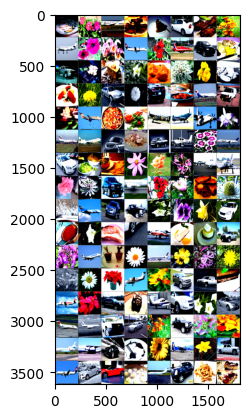

In [ ]:
# Visualize one image from CIFAR
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
#images, labels = dataiter.next()   #Not right
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

#### Step-3: Build a neural network.
Build your convolutional neural networks by adding some layers. You should use 2 convolution layers and ReLU as the default activation function. The kernel size of both layers should be 3x3. Use 32 and 64 as the number of filters for the first and the second convolutional layers, respectively. Set their stride to be 2. After that, flatten your input and add two more dense layers. There should be 1024 units in the first dense with ReLU activation, and use 10 hidden units in the second dense layer with softmax activation. The requirements are same for the following questions.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
    ###### Your code starts here. ######
    #Got from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    # layer definition
        super().__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)  #in chan, out chan, kernel size
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1) #square kernel side = 3
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        # So output will be floor(( i + 2p -k )/stride) + 1
        # which is floor ( 32 +2(1) -3) /2  +1  = 16
        #self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc1 = nn.Linear(64 * 32 * 32, 1024)  #got an error with this, though I think this is right. Try getting rid of 32x32.
        #self.fc1 = nn.Linear(64, 1024)
        self.flatten = nn.Flatten()   #added this
        # So output height/width will be floor(( i + 2p -k )/stride) + 1
        # which is floor ( 32 +2(1) -3) /2  +1  = 16 for the first convolution and 8 for the second convolution

        #Now our image width/height is 224/4=56
        #self.fc1 = nn.Linear(64*8*8, 1024)  #channels, height, width, neurons
        self.fc1 = nn.Linear(64*56*56, 1024)

        #ADD DROPOUT HERE
        #self.fc2 = nn.Linear(120, 84)
        #self.fc2 = nn.Linear(1024, 10)
        self.fc2 = nn.Linear(1024, 100)  #we have 100 classes

        #self.fc3 = nn.Linear(84, 10)

    ###### Your codes end here. ######

    def forward(self, x):
    ###### Your code starts here. ######
    # forwarding definition
        #x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        #x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        #x = self.Flatten(x) #other way to do this
        x = torch.flatten(x, 1) # flatten all dimensions except batch (1 is start dimension, so doesn't flatten rows)
        #print( "x.shape after flatten: ", x.shape)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.softmax(self.fc2(x))    #TA said this was redundant in office hours
        #ADD DROPOUT HERE
        x = self.fc2(x)
        #x = self.fc3(x)
        return x
    ###### Your codes end here. ######

model = SimpleCNN()

#### Step-4: Define loss and optimizer.
use cross_entropy loss and stochastic gradient descent optimizer. Set lr=0.01 and momentum=0.9.

In [ ]:
###### Your code starts here. ######
criterion = nn.CrossEntropyLoss()
#from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

###### Your code ends here. ######

#### Step-5: Training and testing loop.
train your model for 20 epochs. The requirements are same for the following questions. If you do not have access to powerful GPUs, it might take 5-10 minutes to finish one epoch. If you feel you are waiting too long, try smaller networks and less epochs for debugging. But DO NOT forget restore your network definition code and n_epochs to its correct form!

In [ ]:
# Training loop
#def train_loop(model, train_loader, val_loader, criterion, optimizer):
#def train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler=None):
def train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler=None, n_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print( "Using Device:  ")
    print(device)
    #device='cuda'
    #device='cpu'
    #n_epochs = 20
    debugg = True   #TEMP DEBUG
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            ###### Your code starts here. ######
            inputs = inputs.to(device)
            labels = labels.to(device)
            if (debugg):   #DEBUG
               debugg=False
               print("labels on: ")
               print(labels.device)
               print("model on: " )
               print(model.conv1.weight.device)
               print ("inputs on: " )
               print ( inputs.device)

            # do forward-backward propogation, and update the model
            #from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            optimizer.zero_grad()   #zero the parameter gradients. WHY?

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print ( "Grad:",model.conv1.weight.grad)
            #print( "label: ", labels)
            if (scheduler is not None):   #Adding this.
                scheduler.step()

            ###### Your code starts here. ######

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                #
                ###### Your code starts here. ######
                # compute the validation loss and accuracy
                val_loss += criterion(outputs, labels)  #WHY ADD .item() here
                _, predicted = torch.max( outputs.data, 1 )  #from TA Alvin. Vector?
                total +=  labels.size(0) #batch size  #WHY BATCH SIZE

                ###### Your code starts here. ######
                correct += (predicted == labels.squeeze()).sum().item()

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}')

In [ ]:
print(labels.device)
print(model.conv1.weight.device)
#print (inputs.device)  #not in this scope

cpu
cpu


In [ ]:
# Evaluation
'''
def test_loop(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            ###### Your code starts here. ######
            # compute the validation loss and accuracy
            # should be the same as the code for validation set
            test_loss += criterion(outputs, labels)  #WHY ADD .item() here
            _, predicted = torch.max( outputs.data, 1 )  #from TA Alvin. Vector?
            total +=  labels.size(0) #batch size  #WHY BATCH SIZE
            ###### Your code starts here. ######
            correct += (predicted == labels.squeeze()).sum().item()  #WHY .item()  WHY SQUEEZE?

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}')
  '''


"\ndef test_loop(model, test_loader, criterion):\n    model.eval()\n    test_loss = 0.0\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for inputs, labels in test_loader:\n            outputs = model(inputs)\n            ###### Your code starts here. ######\n            # compute the validation loss and accuracy\n            # should be the same as the code for validation set\n            test_loss += criterion(outputs, labels)  #WHY ADD .item() here\n            _, predicted = torch.max( outputs.data, 1 )  #from TA Alvin. Vector?\n            total +=  labels.size(0) #batch size  #WHY BATCH SIZE\n            ###### Your code starts here. ######\n            correct += (predicted == labels.squeeze()).sum().item()  #WHY .item()  WHY SQUEEZE?\n\n    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}')\n  "

In [ ]:
train_loop(model, train_loader, val_loader, criterion, optimizer)
#test_loop(model, test_loader, criterion)  #TODO
# the right implementation should reach an accuracy over 60%, on both val and test set

Using Device:  
cuda


KeyboardInterrupt: ignored

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#FROM: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1')
#model_ft = torchvision.models.resnet50(weights='IMAGENET1K_V1') #or pretrained=True
#model_ft = torchvision.models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
#model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion_ft = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs   TODOl
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#train_loop(model, train_loader, val_loader, criterion, optimizer)
train_loop(model_ft, train_loader, val_loader, criterion_ft, optimizer_ft)
#train_loop(model_ft, train_loader, val_loader, criterion_ft, optimizer_ft, exp_lr_scheduler)

## Fix the features
###Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward()

[From Pytorch Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:")
print( device)

#FROM: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

#Set requires_grad = False to freeze the parameters so that the gradients are not computed
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion_conv = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

train_loop(model_conv, train_loader, val_loader, criterion_conv, optimizer_conv)

## Now fine tune by training the whole network with a low learning rate

In [ ]:
#Set requires_grad = False to freeze the parameters so that the gradients are not computed
for param in model_conv.parameters():
    param.requires_grad = True

#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9) #Reduce learning rate by factor of 10 #didn't increase accuracy
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0005, momentum=0.9) #Reduce learning rate by factor of 2 #helped a bit: 0.1682 to .2243

train_loop(model_conv, train_loader, val_loader, criterion_conv, optimizer_conv)


In [ ]:
'''
!import torchrun

#FROM: https://github.com/pytorch/vision/tree/main/references/classification#mobilenetv3-large--small

!MODEL="mobilenet_v3_small"
!torchrun --nproc_per_node=8 train.py\
      --model $MODEL --epochs 600 --opt rmsprop --batch-size 128 --lr 0.064\
      --wd 0.00001 --lr-step-size 2 --lr-gamma 0.973 --auto-augment imagenet --random-erase 0.2
'''

#### Step-6 Regularization
Add one dropout layer with 0.5 drop rate between the two dense layer. You can keep all other hyperparameters the same.

In [ ]:
'''class SimpleCNN(nn.Module):
    def __init__(self):
    ###### Your code starts here. ######
    # layer definition
        super(SimpleCNN, self).__init__()
        #in chan, out chan, kernel size
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1) #square kernel side = 3
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()   #added this
        # So output height/width will be floor(( i + 2p -k )/stride) + 1
        # which is floor ( 32 +2(1) -3) /2  +1  = 16 for the first convolution and 8 for the second convolution

        self.fc1 = nn.Linear(64*8*8, 1024)
        #ADD DROPOUT HERE
        self.dropout = nn.Dropout( 0.5 )
        self.fc2 = nn.Linear(1024, 10)

    ###### Your codes end here. ######


    def forward(self, x):
    ###### Your code starts here. ######
    # forwarding definition
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = self.Flatten(x) #other way to do this
        x = torch.flatten(x, 1) # flatten all dimensions except batch (1 is start dimension, so doesn't flatten rows)
        #print( "x.shape after flatten: ", x.shape)
        x = F.relu(self.fc1(x))
        #ADD DROPOUT HERE
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    ###### Your codes end here. ######


model = SimpleCNN()
'''

In [ ]:
'''
###### Your code starts here. ######
# do not forget to redefine the loss and optimizer!
#WHY DO WE HAVE TO REDEFINE OPTIMIZER, LOSS CRITERION????

criterion = nn.CrossEntropyLoss()
#from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

###### Your code ends here. ######
'''

In [ ]:
'''
train_loop(model, train_loader, val_loader, criterion, optimizer)
#test_loop(model, test_loader, criterion)   # We have no test set for this project. It's on kaggle.
# the right implementation should lead to an accuracy boost of at least 1.5%, on both val and test set
'''

## We need to create a csv file with predictions to upload to kaggle.


In [ ]:
#This link describes how to do this: https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/2

import os
from datetime import datetime
from natsort import natsorted  #https://stackoverflow.com/questions/3426108/how-to-sort-a-list-of-strings-numerically
from PIL import Image

!date


def submit_test( model, transform, path, model_name="X" ):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #model_name = "X"
  jpegs = natsorted( os.listdir( path + "/test"))
  print (jpegs)

  now = datetime.now()
  timestamp = now.strftime( "%Y-%m-%d-%H-%M") #H isn't working for some reason Colab uses UTC time
  #timestamp = now.strftime( "%Y-%m-%d-%I%p-%M")
  file=open( path + "/submission." + timestamp + "." +model_name + ".csv", "w")
  #print("ID,Label")
  file.write("ID,Label\n")
  model.eval()   # ADD
  with torch.no_grad():
      for jpeg in jpegs:
          #Open the jpeg, convert to inputs
          img_loc = path + "/test/" + jpeg
          image = Image.open(img_loc).convert("RGB")
          input = transform(image)
          input = input.to(device)
          #output = model(input)
          #https://discuss.pytorch.org/t/valueerror-expected-4d-input-got-3d-input/150585
          output = model(input.unsqueeze(0))
          _, prediction = torch.max( output.data, 1 )  #from TA Alvin. Vector?
          prediction = int(prediction) #convert from tensor to int
          #prediction = 99  #TODO REMOVE THIS
          #print( jpeg + "," + str(prediction) )
          file.write( jpeg + "," + str(prediction) + "\n" )
      file.close()



'''
def test_loop(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            ###### Your code starts here. ######
            # compute the validation loss and accuracy
            # should be the same as the code for validation set
            test_loss += criterion(outputs, labels)  #WHY ADD .item() here
            _, predicted = torch.max( outputs.data, 1 )  #from TA Alvin. Vector?
            total +=  labels.size(0) #batch size  #WHY BATCH SIZE
            ###### Your code starts here. ######
            correct += (predicted == labels.squeeze()).sum().item()  #WHY .item()  WHY SQUEEZE?

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}')
 '''




Run the submit function

In [ ]:
#submit_test( model, transform, path, model_name="X" )
submit_test( model_conv, transform, path, model_name="resnet18xfer" )

In [ ]:
submit_test( model_ft, transform, path, model_name="resnet18ft" )

Try resnet152

In [ ]:
model_rn152 = torchvision.models.resnet152(pretrained = True)

#Set requires_grad = False to freeze the parameters so that the gradients are not computed
for param in model_rn152.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_rn152.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 2)
model_rn152.fc = nn.Linear(num_ftrs, 100)

model_rn152 = model_rn152.to(device)

criterion_rn152 = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.001, momentum=0.9)

#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.01, momentum=0.9)
optimizer_rn152 = optim.Adam(model_rn152.fc.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#train_loop(model_rn152, train_loader, val_loader, criterion_conv, optimizer_conv)
train_loop(model_rn152, train_loader, val_loader, criterion_rn152, optimizer_rn152)

In [ ]:
submit_test( model_rn152, transform, path, model_name="resnet152frozen" )

In [ ]:
#list( model_rn152.modules())

Fine tune resnet152 parameters

In [ ]:
#Set requires_grad = False to freeze the parameters so that the gradients are not computed
for param in model_rn152.parameters():
    param.requires_grad = True


train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True) #20?  was 128
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False) #20?  was 128

#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9) #Reduce learning rate by factor of 10 #didn't increase accuracy
#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.0005, momentum=0.9) #Reduce learning rate by factor of 2 #helped a bit: 0.1682 to .2243

#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.001, momentum=0.9)  #This is now 1/10 of resnet152 learning rate.
optimizer_rn152 = optim.Adam(model_rn152.fc.parameters(), lr=0.001)

train_loop(model_rn152, train_loader, val_loader, criterion_rn152, optimizer_rn152)

In [ ]:
submit_test( model_rn152, transform, path, model_name="resnet152tuned" )

In [ ]:
torch.save( model_rn152, path + '/models/model_rn152tuned3.pt')

In [ ]:
torch.cuda.memory_summary()

## Save the output activations to a file for an ensemble prediction

In [ ]:
import pandas as pd
from natsort import natsorted
#print(model_rn152)
#model_rn152=None
#print( model_rn152)
#model_rn152 = torch.load( path + '/models/model_rn152tuned2.pt' )
model_rn152 = torch.load( path + '/models/model_rn152tuned3.pt' )
#print( model_rn152)
model = model_rn152
y_prob = pd.DataFrame(columns=['ID'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
jpegs = natsorted( os.listdir( path + "/test"))
with torch.no_grad():
   for jpeg in jpegs:
        #Open the jpeg, convert to inputs
        img_loc = path + "/test/" + jpeg
        image = Image.open(img_loc).convert("RGB")
        input = transform(image)
        input = input.to(device)
        #output = model(input)
        #https://discuss.pytorch.org/t/valueerror-expected-4d-input-got-3d-input/150585
        outputs = model(input.unsqueeze(0))



        #for inputs, _, file_name in test_loader:
        #inputs = inputs.to(device)
        #outputs = model(inputs)
        # Get the probability
        prob = F.softmax(outputs, dim=1).cpu().numpy()
        prob = pd.DataFrame(prob)
        #df = pd.DataFrame(file_name, columns=['ID'])
        df = pd.DataFrame([int(jpeg[:-4])], columns=['ID'])

        #df = pd.DataFrame( columns=['ID']) #got error
        #df['ID'] = jpeg

        # concat the probability and file name
        df = pd.concat([df, prob], axis=1)

        y_prob = pd.concat([y_prob, df], ignore_index=True)
        #y_prob = pd.concat([y_prob, prob])
y_prob= y_prob.sort_values('ID').reset_index(drop=True)

y_prob





In [ ]:
y_prob.to_csv(path + '/models/resnet152outputs.csv')

jpegs = natsorted( os.listdir( path + "/test"))

#jpegs
x = torch.zeros( (5,6))
x = torch.zeros( len( jpegs), 100 )





##Try a wide resnet50 and wide resnet101

In [ ]:
torch.manual_seed(42)  #in case you want to rerun different code blocks out of order.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Reduce batch size:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True) #20?  was 128
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False) #20?  was 128

#model_rn152 = torchvision.models.resnet152(pretrained = True)
model_wrn50 = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet101_2', pretrained=True)


#Set requires_grad = False to freeze the parameters so that the gradients are not computed
for param in model_wrn50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_wrn50.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 2)
model_wrn50.fc = nn.Linear(num_ftrs, 100)

model_wrn50 = model_wrn50.to(device)

criterion_wrn50 = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.001, momentum=0.9)

#optimizer_rn152 = optim.SGD(model_rn152.fc.parameters(), lr=0.01, momentum=0.9)
optimizer_wrn50 = optim.Adam(model_wrn50.fc.parameters(), lr=0.01)

n_epochs = 40
scheduler_wrn50  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_wrn50, T_max=n_epochs, eta_min=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#train_loop(model_rn152, train_loader, val_loader, criterion_conv, optimizer_conv)
train_loop(model_wrn50, train_loader, val_loader, criterion_wrn50, optimizer_wrn50, scheduler=scheduler_wrn50, n_epochs=n_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using Device:  
cuda
labels on: 
cuda:0
model on: 
cuda:0
inputs on: 
cuda:0
Epoch 1/40, Loss: 3.4629, Accuracy: 0.2523
Epoch 2/40, Loss: 4.6870, Accuracy: 0.2897
Epoch 3/40, Loss: 3.2183, Accuracy: 0.3925
Epoch 4/40, Loss: 2.8092, Accuracy: 0.4486
Epoch 5/40, Loss: 4.1093, Accuracy: 0.3925
Epoch 6/40, Loss: 2.2902, Accuracy: 0.5234
Epoch 7/40, Loss: 4.3214, Accuracy: 0.3458
Epoch 8/40, Loss: 3.9974, Accuracy: 0.4393
Epoch 9/40, Loss: 3.2672, Accuracy: 0.4860
Epoch 10/40, Loss: 4.5123, Accuracy: 0.4393
Epoch 11/40, Loss: 3.3231, Accuracy: 0.4579
Epoch 12/40, Loss: 4.2575, Accuracy: 0.4299
Epoch 13/40, Loss: 4.7693, Accuracy: 0.4393
Epoch 14/40, Loss: 3.9344, Accuracy: 0.4766
Epoch 15/40, Loss: 6.9044, Accuracy: 0.3178
Epoch 16/40, Loss: 4.4325, Accuracy: 0.4486
Epoch 17/40, Loss: 4.2004, Accuracy: 0.4393
Epoch 18/40, Loss: 6.5575, Accuracy: 0.3645
Epoch 19/40, Loss: 4.1358, Accuracy: 0.4393
Epoch 20/40, Loss: 6.5445, Accuracy: 0.4019
Epoch 21/40, Loss: 4.3233, Accuracy: 0.4766
Epoch 22

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

1.   List item
2.   List item

